# Quantum mechanical scattering

In this notebook, we will perform numerical calculations for elastic scattering in 3D space, using the [Numpy](https://numpy.org/), [Scipy](https://scipy.org/), and [Matplotlib](https://matplotlib.org/) Python libraries.

## Recap: the Born series

When a nonrelativistic quantum particle of energy $E$ and mass $m$ scatters off a fixed potential, the key quantity of interest is the **scattering amplitude**, $f(\mathbf{k}_i\rightarrow\mathbf{k}_f)$. This is the (complex) quantum amplitude for an incoming plane wave of wavevector $\mathbf{k}_i$ to scatter to wavevector $\mathbf{k}_f$. We assume elastic collisions, so

$$|\mathbf{k}_i| = |\mathbf{k}_f| \equiv k = \sqrt{\frac{2mE}{\hbar^2}}.$$

The scattering amplitude can be expressed using the **Born series**,

$$f(\mathbf{k}_i\rightarrow \mathbf{k}_f) \approx - \frac{2m}{\hbar^2} \,\cdot \, 2\pi^2 \, \Bigg[\big\langle \mathbf{k}_f\big| \hat{V}\big|\mathbf{k}_i\big\rangle + \big\langle \mathbf{k}_f \big| \hat{V}\hat{G}_0 \hat{V} \big|\mathbf{k}_i\big\rangle + \cdots \Bigg],$$

where $\hat{V}$ is the scattering potential operator. The terms in the square brackets are bra-kets involving delta-normalized momentum eigenstates; e.g., $|\mathbf{k}_i\rangle$ denotes an eigenstate of wavevector $\mathbf{k}_i$. In the position representation, these bra-kets become integrals over space. For example, the first two terms are:

$$\begin{aligned}\big\langle \mathbf{k}_f\big| \hat{V}\big|\mathbf{k}_i\big\rangle &= \int d^3r_1\; \langle \mathbf{k}_f | \mathbf{r}_1\rangle \, V(\mathbf{r}_1) \, \langle \mathbf{r}_1 | \mathbf{k}_i\rangle \\ &= \frac{1}{(2\pi)^3} \int d^3r_1\; V(\mathbf{r}_1) \; \exp\Big[i(\mathbf{k}_i-\mathbf{k}_f) \cdot \mathbf{r}_1\Big], \\ \big\langle \mathbf{k}_f\big| \hat{V} \hat{G}_0\hat{V}\big|\mathbf{k}_i\big\rangle &= \int d^3r_1\; \int d^3r_2 \; \langle \mathbf{k}_f | \mathbf{r}_1\rangle \, V(\mathbf{r}_1) \, \langle\mathbf{r}_1 |\hat{G}_0| \mathbf{r}_2\rangle\, V(\mathbf{r}_2) \, \langle \mathbf{r}_2 | \mathbf{k}_i\rangle \\
&= - \frac{1}{(2\pi)^3} \frac{2m}{\hbar^2} \int d^3r_1 d^3r_2 \; V(\mathbf{r}_1) \; V(\mathbf{r}_2) \; \exp\Big[i\big(\mathbf{k}_i\cdot \mathbf{r}_1 - \mathbf{k}_f \cdot \mathbf{r}_2\big)\Big] \; \frac{\exp[ik|\mathbf{r}_1 - \mathbf{r}_2|]}{4\pi|\mathbf{r}_1 - \mathbf{r}_2|}.\end{aligned}$$

## Monte Carlo integration

An expedient way to calculate complicated nested integrals, like those in the Born series, is [Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration). Suppose we want to compute

$$I = \int_{V} d^Dr \, F(\mathbf{r}),$$

where $V$ denotes some $D$-dimensional volume of integration.  To do this, we randomly sample $N$ points, $\{F_1, F_2, \dots, F_N\}$, from the volume $V$, and then put them into the formula

$$I \,\approx\, \frac{V}{N} \sum_{n=1}^N F_n.$$

An easy way to think about this is that $(1/N) \sum_n F_n$ approximates the average value of the integrand over $V$; thus, multiplying it by $V$ yields the integral.

## Starter code for the Born series calculation

Below, you are given some (already working) code to calculate the first term in the Born series.

In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

## Function to estimate the first Born contribution to the scattering amplitude f.
## The inputs are:
##
## Vfun   -- A function object.  The function should take an array [x, y, z]
##           and (optionally) other parameters. It should return V(x,y,z).
## ki, kf -- Initial and final wavevectors, which should have equal magnitudes.
## L      -- Size of sampling box.  Each coordinate is drawn from [-L, L].
## N      -- Number of Monte Carlo runs; default is 5000.
## Vargs  -- A tuple of additional parameters to pass Vfun.

def fborn1(Vfun, ki, kf, L, N, Vargs=()):
    volume = (2*L)**3    # Spatial volume of integration
    f1 = 0.0             # Scattering amplitude
    for n in range(N):
        r1  = 2 * L * np.random.random(3) - L # Each coordinate is -L to L
        dkr = np.dot(ki - kf, r1)
        f1 += - Vfun(r1, *Vargs) * np.exp(1j * dkr) / (2 * np.pi)
    return volume * f1 / N

Here, and in all the rest of the notebook, we will assume computational units: $m = \hbar = 1$. In these units, the first Born series term is

$$f^{(1)}(\mathbf{k}_i\rightarrow \mathbf{k}_f) = - \frac{1}{2\pi} \int d^3 r_1 \; V(\mathbf{r}_1)\, \exp\Big[i(\mathbf{k}_i-\mathbf{k}_f) \cdot \mathbf{r}_1\Big].$$

The `fborn1` function is intended to work for *arbitrary* scattering potentials, specified by a caller-supplied Python function (the `Vfun` input). This allows the code to be re-used for different scatterers. For extra flexibility, `fborn1` optionally accepts a set of additional parameters, `Vargs`, which get passed on to `Vfun` as additional inputs (we will see a usage example below).

In each Monte Carlo iteration, the function draws a random 3D position from a cube of side $2L$, centered at the origin, i.e., each position coordinate is drawn uniformly from $[-L, L]$. We then use `Vfun` to calculate the integrand at that sampling point, and add up the results. After repeating this $N$ times, we divide by $N$ to obtain the mean, then multiply by the volume $V = (2L)^3$ to get the Monte Carlo estimate.

# Task 1: Second Born term (5 marks)

Write a function `fborn2` to calculate the second-order term in the Born series.  For $\hbar = m = 1$,


$$f^{(2)} = \frac{1}{4\pi^2} \int d^3 r_1 \int d^3r_2  V(\mathbf{r}_1) \; V(\mathbf{r}_2) \; \exp\Big[i\big(\mathbf{k}_i\cdot \mathbf{r}_1 - \mathbf{k}_f \cdot \mathbf{r}_2\big)\Big] \; \frac{\exp[ik|\mathbf{r}_1 - \mathbf{r}_2|]}{|\mathbf{r}_1 - \mathbf{r}_2|}.$$

Hints:
* The double integral can be sampled using a *single* Monte Carlo loop. Don't use two nested loops!
* Think about what the "volume" in the Monte Carlo formula should be. Is it $(2L)^3$, like in the first Born integral, or something else?

In [2]:
## Function to estimate the first Born contribution to the scattering amplitude f.
def fborn2(Vfun, ki, kf, L, N=5000, Vargs=()):
    # Fill in code here
    return 0.0 # FIXME.

## Born series: plotting the results

Let us use the above code to generate some results.

First, we define a simple spherical scatterer,

$$V(\mathbf{r}) = \begin{cases}-U, & |\mathbf{r}| < R \\ 0 & \mathrm{otherwise}.\end{cases}$$

This describes a potential well for $U > 0$, and a barrier for $U < 0$. The potential is implemented using this Python function:

In [3]:
## Spherical step potential which is U for r < R, and 0 outside
def spherical_step_potential(r, U, R):
    return -U if scipy.linalg.norm(r) < R else 0.0

This function can be used as the `Vfun` input to `fborn1` and `fborn2`. Note that in addition to the position `r`, it accepts two additional inputs, `U` and `R`. 

Now, the following code plots the energy dependence of $|f|^2$ for 90-degree deflection angles:

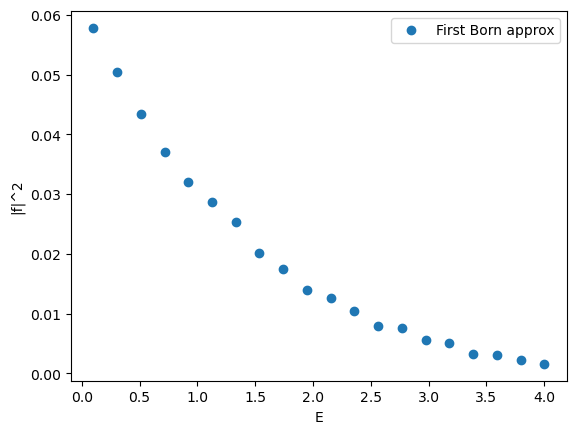

In [11]:
## Plot the differential scattering cross section versus energy E, with
## incident wavevector along (0,0,1) and scattered wavevector along (1,0,0).

def scattering_vs_E_born1():
    U, R = 0.5, 0.9                 # Potential parameters
    Nmc, Lmc = 5000, 1.0            # Monte Carlo parameters
    Emin, Emax, numE = 0.1, 4.0, 20 # For plotting

    Evec = np.linspace(Emin, Emax, numE)
    fvec = np.zeros(numE, dtype=complex) # scattering amplitudes to calculate

    for n in range(numE):
        k  = np.sqrt(2*Evec[n])
        ki = np.array([0,0,k]) # incident along z
        kf = np.array([k,0,0]) # 90-degree deflection
        fvec[n] = fborn1(spherical_step_potential, ki, kf, Lmc, Nmc, (U, R))

    plt.plot(Evec, abs(fvec)**2, 'o', label='First Born approx')
    plt.xlabel('E'); plt.ylabel('|f|^2'); plt.legend()
    plt.show()

scattering_vs_E_born1()

# Task 2: Plotting the second Born approximation (5 marks)

By modifying the above code, write a function to plot both the first Born approximation and second Born approximation, **in a single plot**.

Hints:
* The second Born approximation refers to $f^{(1)} + f^{(2)}$, not just $f^{(2)}$.
* Be sure to label the two cases clearly.

In [5]:
def scattering_vs_E_born2():
    ## Fill in code here
    return

scattering_vs_E_born2()

# Task 3: deflection angle dependence (5 marks)

By writing new code, study how $|f|^2$ varies with deflection angle $\theta$, in the first and second Born approximations, for the simple spherical scatterer.

You are free to choose the incident wave-vector $\mathbf{k}_i$. The deflection angle $\theta$ is the angle of $\mathbf{k}_f$ relative to $\mathbf{k}_i$ (when $\theta = 0$, they point in the same direction); you can pick the plane in which to place $\mathbf{k}_f$. Please re-use the previously-defined `fborn1` and `fborn2`, rather than creating new versions of those functions.

Generate some relevant plots, and then write up some interpretations for your results. For instance, are the forwards, sideways, or backwards scattering amplitudes affected differently by the energy and/or the strength of the scatterer? Can you explain why this happens?

In [2]:
## Fill in code here

*Discuss your results here*

# Task 4: non-spherical scatterer (5 marks)

Investigate the scattering amplitudes for a non-spherical scatterer with a "long axis", such as a stretched-out cylinder or ellipsoid.

You will need to write a new scattering potential function; you are free to decide on its details (but please explain your choices). Once again, you are to re-use the previously-defined `fborn1` and `fborn2` functions, rather than creating new versions.

Study how the scatterer's orientation affects the scattering. For example, is there any difference when the scatterer's axis is aligned parallel to the incident wave, or perpendicular to it? Discuss your results, and support them with some relevant plots.

In [ ]:
## Fill in code here

*Discuss your results here*

# Task 5: quantitative verification (10 marks)

Finally, let us compare the Born approximation with the exact results for a uniform spherical scatterer.

The derivation of the exact scattering amplitude, based on partial wave analysis, is given in Appendix A of the course notes. The end result is

$$\begin{aligned}f(\mathbf{k}_i \rightarrow k\hat{\mathbf{r}}) &= \frac{1}{2ik}\, \sum_{\ell =0}^\infty \big(e^{2i\delta_\ell} - 1\big) \big(2\ell+1\big)\, P_{\ell}(\hat{\mathbf{k}}_i\cdot \hat{\mathbf{r}}) \\ \delta_\ell &= \frac{\pi}{2} - \mathrm{arg}\!\left[k{h_\ell^+}'(kR) \, j_\ell(qR) - qh_\ell^+(kR)\, j_\ell'(qR)\right] \\ k &= |\mathbf{k}_i| = \sqrt{2mE/\hbar^2}, \;\; q = \sqrt{2m(E+U)/\hbar^2},\end{aligned}$$

where $V_0$ is the potential inside the sphere of radius $R$.

Write a program to plot $|f|^2$ versus $E$ for (i) first-order Born, (ii) second-order Born, and (iii) the exact result, on a single graph.

Hints:
* To compute the Legendre polynomials $P_\ell(x)$, use [`scipy.special.lpmv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.lpmv.html).<br />Note that $P_\ell$ is what the documentation refers to as $P_\ell^0$ (i.e., the "zeroth-order" associate Lgendre polynomial).
* To compute the spherical Hankel function of the first kind ($h_\ell^+$) or its derivative (${h_\ell^+}'$), use the identity $h_\ell^+ = j_\ell + i y_\ell$.
* To compute the spherical Bessel function of the first kind ($j_\ell$) or its first derivative ($j_\ell'$), use [`scipy.special.spherical_jn`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.spherical_jn.html).
* To compute the spherical Bessel function of the second kind ($y_\ell$) or its first derivative ($y_\ell'$), use [`scipy.special.spherical_yn`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.spherical_yn.html).
* The argument of a complex number can be calculated using [`numpy.angle`](https://numpy.org/doc/stable/reference/generated/numpy.angle.html).

In [6]:
## Fill in code here